In [1]:
from __future__ import annotations
from typing import Tuple, Dict, Any

from torch.utils.data import DataLoader

from src.types.task_protocol import TaskProtocol
from src.datasets.ptbxl.ptbxl_dataloader import make_ptbxl_loaders

class PTBXLTask(TaskProtocol):
    """
    PTB-XL ECG classification task.
    - Multi-label classification (5 superclasses: NORM, MI, STTC, HYP, CD)
    - Input: 12-lead ECG signals
    - Sampling rate: 100Hz (lr100) or 500Hz (hr500)
    """
    problem_type: str = "multilabel"

    def make_loaders(
        self,
        data_root: str,
        batch_size: int = 64,
        num_workers: int = 4,
        **kwargs
    ) -> Tuple[DataLoader, DataLoader, DataLoader]:
        """
        Returns: (train_loader, val_loader, test_loader)
        with x: (B, T, D), y: (B, 5) for multi-label classification
        """
        sampling = kwargs.get("sampling", "lr100")
        length = kwargs.get("length", 1000)
        leads = kwargs.get("leads", None)
        folds_train = kwargs.get("folds_train", (1, 2, 3, 4, 5, 6, 7, 8))
        fold_val = kwargs.get("fold_val", 9)
        fold_test = kwargs.get("fold_test", 10)

        return make_ptbxl_loaders(
            data_root=data_root,
            batch_size=batch_size,
            num_workers=num_workers,
            sampling=sampling,
            length=length,
            leads=leads,
            folds_train=folds_train,
            fold_val=fold_val,
            fold_test=fold_test,
        )

    def infer_input_dim(self, args: Dict[str, Any]) -> int:
        """Number of leads (channels)"""
        leads = args.get("leads", None)
        return len(leads) if leads is not None else 12

    def infer_num_classes(self, args: Dict[str, Any]) -> int:
        """Number of superclasses for multi-label classification"""
        return 5  # NORM, MI, STTC, HYP, CD

    def infer_theta(self, args: Dict[str, Any]) -> int:
        """Sequence length (number of time steps)"""
        return args.get("length", 1000)


def create_block_cfg_ctor(dropout: float, mlp_ratio: float, droppath_final: float,
                          layerscale_init: float, residual_gain: float, pool: str):
    """Create a block config constructor with the given hyperparameters."""
    def block_cfg_ctor(theta: int) -> BlockConfig:
        return BlockConfig(
            kind="lmu",
            memory_size=256,
            theta=theta,
            dropout=dropout,
            mlp_ratio=mlp_ratio,
            droppath_final=droppath_final,
            layerscale_init=layerscale_init,
            residual_gain=residual_gain,
            pool=pool,
        )
    return block_cfg_ctor


In [2]:
import torch
from pathlib import Path

current_dir = Path.cwd()
project_root = current_dir.parent.parent.parent # Go up from src/notebooks/ to project root
data_root = str(project_root / "src" / "datasets" / "ptbxl" / "data")

args: Dict[str, Any] = {
        # data
        "data_root": str(data_root),
        "batch": 32,  # ⬇️ Reduced for MPS memory constraints
        "data_loader_kwargs": {
            "num_workers": 0,  # ⚠️ CRITICAL for Mac - avoids 3x slowdown!
            "sampling": "lr100",  # 100Hz sampling rate
            "length": 1000,       # 10 seconds at 100Hz
            "leads": None,        # Use all 12 leads
            "folds_train": (1, 2, 3, 4, 5, 6, 7, 8),
            "fold_val": 9,
            "fold_test": 10,
            "pin_memory": False,  # Not needed for MPS
            "persistent_workers": False,
        },

        # training
        "epochs": 100,
        "lr": 1e-3,
        "wd": 1e-4,
        "amp": True,  # M4 MPS works well with AMP
        "save_dir": "./runs/ptbxl_task",
        "warmup_epochs": 5,
        "patience": 10,
        "min_delta": 0.001,
        "threshold": 0.5,      # For multi-label classification
        "early_key": "f1_micro",  # Use F1-micro for early stopping

        # model scaffold
        "d_model": 256,
        "depth": 6,
        "dropout": 0.3, #0.2,
        "mlp_ratio": 2.0,
        "droppath_final": 0.2, #0.1,
        "layerscale_init": 1e-2,
        "residual_gain": 1.0,
        "pool": "mean",
    }

args["block_cfg_ctor"] = create_block_cfg_ctor(
    dropout=args["dropout"],
    mlp_ratio=args["mlp_ratio"],
    droppath_final=args["droppath_final"],
    layerscale_init=args["layerscale_init"],
    residual_gain=args["residual_gain"],
    pool=args["pool"],
)

# M4-optimized device selection
if torch.backends.mps.is_available():
    args["device"] = torch.device("mps")
    print("🚀 Using MPS (M4 Neural Engine)")
elif torch.cuda.is_available():
    args["device"] = torch.device("cuda")
else:
    args["device"] = torch.device("cpu")
    args["amp"] = False

🚀 Using MPS (M4 Neural Engine)


In [3]:
from typing import Dict, Any

import torch
import os

from src.train_utils.trainer import Trainer
from src.models.v2.build_model import BlockConfig, build_model

def main() -> None:
    task = PTBXLTask()

    # M4-optimized MPS settings
    if torch.backends.mps.is_available():
        torch.mps.set_per_process_memory_fraction(0.9)
        os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

    trainer = Trainer(args=args, task=task, model_builder=build_model)

    best_metric, ckpt_path = trainer.fit()
    print(f"Done. Best {trainer.early_key}={best_metric:.4f} @ {ckpt_path}")
    return trainer


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [6]:
main()

/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

new best f1_micro 0.2520
Epoch 000/100 | train 0.7351/0.2693 | val 0.7185/0.2520 | t 546.6s/24.3s | lr 1.00e-06


new best f1_micro 0.5519
Epoch 001/100 | train 0.4384/0.4805 | val 0.4125/0.5519 | t 788.2s/22.1s | lr 2.01e-04


new best f1_micro 0.6310
Epoch 002/100 | train 0.3892/0.6055 | val 0.3821/0.6310 | t 536.7s/24.3s | lr 4.01e-04


new best f1_micro 0.6483
Epoch 003/100 | train 0.3616/0.6531 | val 0.3807/0.6483 | t 587.6s/25.9s | lr 6.00e-04


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 004/100 | train 0.3436/0.6782 | val 0.3562/0.6452 | t 591.5s/22.0s | lr 8.00e-04


new best f1_micro 0.6779
Epoch 005/100 | train 0.3268/0.7002 | val 0.3699/0.6779 | t 548.3s/26.1s | lr 1.00e-03


new best f1_micro 0.7097
Epoch 006/100 | train 0.3093/0.7225 | val 0.3545/0.7097 | t 606.2s/22.2s | lr 1.00e-03


Epoch 007/100 | train 0.2921/0.7397 | val 0.3709/0.6925 | t 570.6s/24.9s | lr 9.99e-04


Epoch 008/100 | train 0.2742/0.7610 | val 0.3741/0.6937 | t 640.4s/26.9s | lr 9.98e-04


new best f1_micro 0.7145
Epoch 009/100 | train 0.2573/0.7787 | val 0.3633/0.7145 | t 622.0s/27.7s | lr 9.96e-04


⏹ Early stopping (patience=10, best=0.7145).
📊 Training history saved to ./runs/ptbxl_task/history.json
Done. Best f1_micro=0.7145 @ ./runs/ptbxl_task/best.pt


In [5]:
def load_trainer_from_checkpoint(checkpoint_path: str, args: Dict[str, Any], task: TaskProtocol) -> Trainer:
    """Load trainer from checkpoint with minimal code duplication."""
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=args["device"])

    # Create new trainer instance with same args
    trainer = Trainer(args=args, task=task, model_builder=build_model)

    # Restore state
    trainer.model.load_state_dict(checkpoint["model"])
    if "optimizer" in checkpoint:
        trainer.opt.load_state_dict(checkpoint["optimizer"])
    if "scheduler" in checkpoint:
        trainer.scheduler.load_state_dict(checkpoint["scheduler"])
    if "history" in checkpoint:
        trainer.history = checkpoint["history"]

    print(f"✅ Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"📊 Val metrics: {checkpoint.get('val', {})}")

    return trainer


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

✅ Loaded checkpoint from epoch 9
📊 Val metrics: {'loss': 0.36332853276382776, 'time_s': 27.733132791999196, 'f1_micro': 0.7144750319309069}


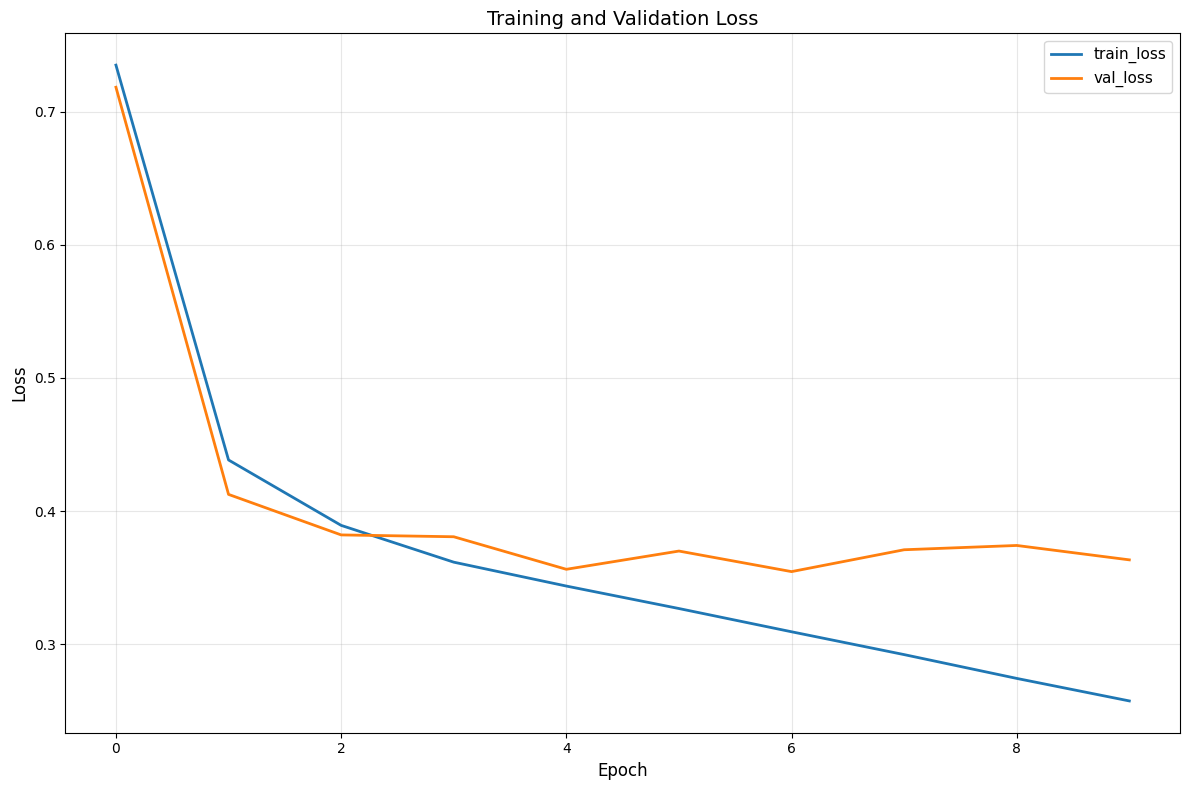

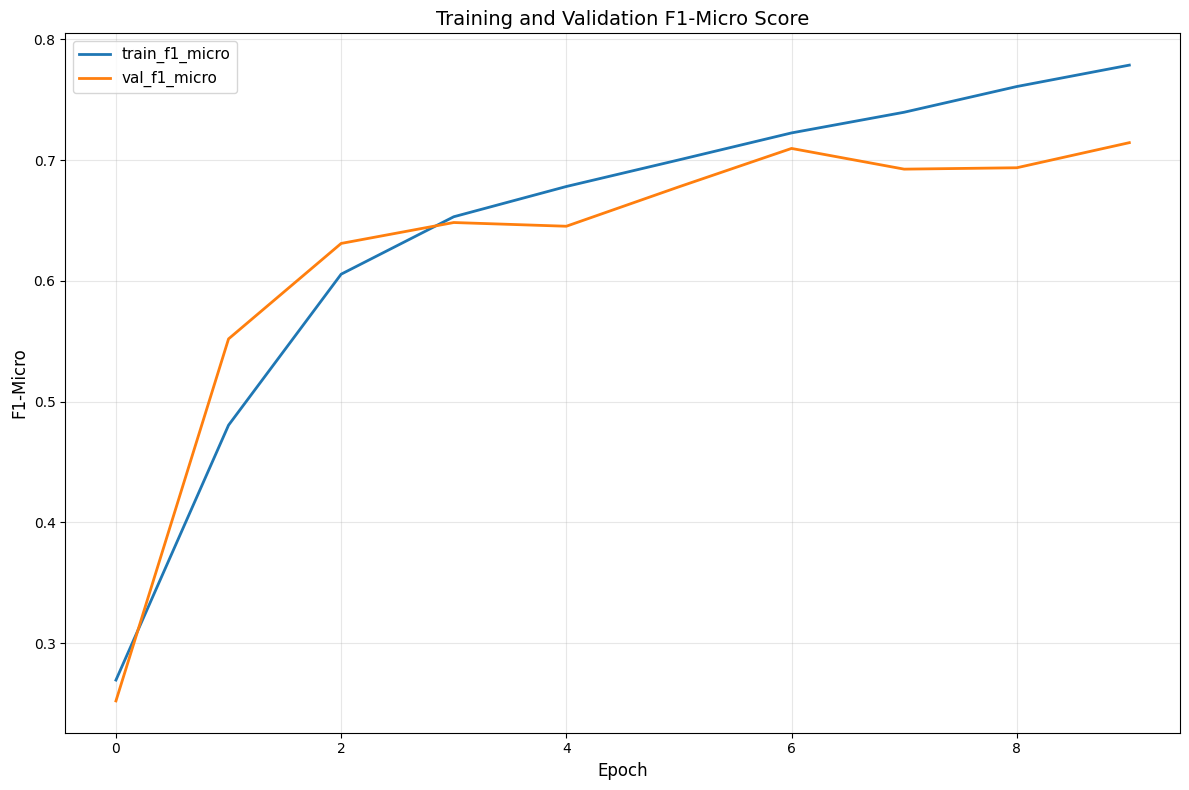

In [6]:
import matplotlib.pyplot as plt

trainer = load_trainer_from_checkpoint(
    checkpoint_path="./runs/ptbxl_task/best.pt",
    args=args,
    task=PTBXLTask()
)

history = trainer.history

# Loss plot
plt.figure(figsize=(12, 8))
plt.plot(history["train_loss"], label="train_loss", linewidth=2)
plt.plot(history["val_loss"], label="val_loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.title("Training and Validation Loss", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# F1-Micro plot
plt.figure(figsize=(12, 8))
plt.plot(history["train_f1_micro"], label="train_f1_micro", linewidth=2)
plt.plot(history["val_f1_micro"], label="val_f1_micro", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("F1-Micro", fontsize=12)
plt.legend(fontsize=11)
plt.title("Training and Validation F1-Micro Score", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Evaluation and Visualization
import os
import torch
import matplotlib.pyplot as plt
from src.eval.infer import predict_loader
from src.utils.common import amp_autocast

def evaluate_best_model():
    """Load best checkpoint and evaluate on validation set."""
    task = PTBXLTask()

    # Recreate data loaders
    _, val_loader, test_loader = task.make_loaders(
        data_root=data_root,
        batch_size=32,  # Match training batch size
        num_workers=0,  # Same as training for consistency
        sampling="lr100",
        length=1000,
        leads=None,
        folds_train=(1, 2, 3, 4, 5, 6, 7, 8),
        fold_val=9,
        fold_test=10,
    )

    # Load best checkpoint
    best_ckpt_path = "./runs/ptbxl_task/best.pt"
    if not os.path.exists(best_ckpt_path):
        print(f"Checkpoint not found at {best_ckpt_path}")
        return

    best_ckpt = torch.load(best_ckpt_path, map_location="cpu")

    # Recreate model
    from src.models.v2.build_model import BlockConfig, build_model

    d_in = 12  # 12 leads
    n_classes = 5  # 5 superclasses
    theta = 1000  # sequence length

    block_cfg = BlockConfig(
        kind="lmu",
        memory_size=256,
        theta=theta,
        dropout=0.2,
        mlp_ratio=2.0,
        droppath_final=0.1,
        layerscale_init=1e-2,
        residual_gain=1.0,
        pool="mean",
    )

    model = build_model(
        d_in=d_in,
        n_classes=n_classes,
        d_model=256,
        depth=6,
        block_cfg=block_cfg,
    )

    # Load weights
    model.load_state_dict(best_ckpt["model"])

    # Set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model.to(device)
    amp = device.type in {"cuda", "mps"}

    print(f"Loaded checkpoint from epoch {best_ckpt['epoch']}")
    print(f"Val metrics: {best_ckpt['val']}")

    # Get predictions on validation set
    logits_val, labels_val = predict_loader(model, val_loader, device, amp_autocast, amp)

    # Get predictions on test set
    logits_test, labels_test = predict_loader(model, test_loader, device, amp_autocast, amp)

    # For multi-label, compute metrics manually
    from src.utils.metrics import multilabel_metrics_fn

    threshold = 0.5
    metrics_fn = multilabel_metrics_fn(threshold=threshold)

    print("\n" + "="*50)
    print("VALIDATION SET RESULTS:")
    print("="*50)
    val_metrics = metrics_fn(logits_val, labels_val)
    for k, v in val_metrics.items():
        print(f"{k}: {v:.4f}")

    print("\n" + "="*50)
    print("TEST SET RESULTS:")
    print("="*50)
    test_metrics = metrics_fn(logits_test, labels_test)
    for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}")

    # Per-class analysis
    preds_val = (torch.sigmoid(logits_val) > threshold).float()
    preds_test = (torch.sigmoid(logits_test) > threshold).float()

    class_names = ["NORM", "MI", "STTC", "HYP", "CD"]

    print("\n" + "="*50)
    print("PER-CLASS F1 SCORES (Validation):")
    print("="*50)
    for i, name in enumerate(class_names):
        tp = ((preds_val[:, i] == 1) & (labels_val[:, i] == 1)).sum().item()
        fp = ((preds_val[:, i] == 1) & (labels_val[:, i] == 0)).sum().item()
        fn = ((preds_val[:, i] == 0) & (labels_val[:, i] == 1)).sum().item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        support = labels_val[:, i].sum().item()
        print(f"{name:8s}: F1={f1:.4f} (P={precision:.4f}, R={recall:.4f}, support={int(support)})")

    print("\n" + "="*50)
    print("PER-CLASS F1 SCORES (Test):")
    print("="*50)
    for i, name in enumerate(class_names):
        tp = ((preds_test[:, i] == 1) & (labels_test[:, i] == 1)).sum().item()
        fp = ((preds_test[:, i] == 1) & (labels_test[:, i] == 0)).sum().item()
        fn = ((preds_test[:, i] == 0) & (labels_test[:, i] == 1)).sum().item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        support = labels_test[:, i].sum().item()
        print(f"{name:8s}: F1={f1:.4f} (P={precision:.4f}, R={recall:.4f}, support={int(support)})")

evaluate_best_model()

/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

Loaded checkpoint from epoch 9
Val metrics: {'loss': 0.36332853276382776, 'time_s': 27.733132791999196, 'f1_micro': 0.7144750319309069}


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



VALIDATION SET RESULTS:
f1_micro: 0.7159

TEST SET RESULTS:
f1_micro: 0.7103

PER-CLASS F1 SCORES (Validation):
NORM    : F1=0.8287 (P=0.7916, R=0.8694, support=957)
MI      : F1=0.6955 (P=0.6820, R=0.7096, support=544)
STTC    : F1=0.6858 (P=0.7284, R=0.6479, support=534)
HYP     : F1=0.2682 (P=0.5517, R=0.1771, support=271)
CD      : F1=0.7007 (P=0.8274, R=0.6076, support=497)

PER-CLASS F1 SCORES (Test):
NORM    : F1=0.8313 (P=0.7947, R=0.8714, support=964)
MI      : F1=0.6786 (P=0.6738, R=0.6835, support=553)
STTC    : F1=0.6975 (P=0.7352, R=0.6635, support=523)
HYP     : F1=0.3424 (P=0.6000, R=0.2395, support=263)
CD      : F1=0.6397 (P=0.7527, R=0.5562, support=498)


In [8]:
from src.utils.common import print_model_details

print_model_details(model=trainer.model)


                            MODEL DETAILS                             

                             ARCHITECTURE                             
----------------------------------------------------------------------
Model Type: SeqClassifier
Core Layer Type: LMUCoreAdapter
Number of Blocks: 6

                              PARAMETERS                              
----------------------------------------------------------------------
Total parameters:              3,170,827
Trainable parameters:          3,170,827
Non-trainable parameters:              0
Model size (MB):                   12.10

                           MODEL ATTRIBUTES                           
----------------------------------------------------------------------

                           MODULE BREAKDOWN                           
----------------------------------------------------------------------
proj                           Linear                              3,328
blocks                         ModuleList